Here, you develop the E+M Runge-Kuttas. (You want to be able to graph two functions at a time. The plotting functions can handle it, but the other functions aren't built for it specifically because your cases are simple enough that the answer for the B field is proportional to the E Field.)

In [1]:
import os.path
import numpy as np
import scipy as sp
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 16
refRatio = 2
CFL = np.sqrt(0.5)
ntC = 4
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'U'
RK = 4
order = 1

L = 1
locs = [x_1]
epsilons = [1, 0.5] # [1, 1]
mus = [1, 0.5] # [1, 1]

func = WFT.Gauss # SquareWave
plotCont = True
enlarge = False

In [3]:
omegaC = BT.Grid(nh_min)
physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cC = physicsC.cVec
cMatC = physicsC.cMat
matIndC = physicsC.matInd
finepart = list(np.arange(matIndC - order, matIndC + order))

omegaAMR = BT.Grid(nh_min)
omegaAMR.AddPatch(refRatio, finepart)
physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
c = physicsAMR.cVec
cMatAMR = physicsAMR.cMat
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cF = physicsF.cVec
cMatF = physicsF.cMat


wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
nullspaceBlock = OT.Block(nullspace, var = 2)
restrictOp = GTT.CoarsenOp(omegaAMR)
restrictOpBlock = OT.Block(restrictOp, var = 2)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)

In [4]:
cVecC = physicsC.cVec
c1 = cVecC[0]
c2 = cVecC[-1]

In [5]:
# sigma, mu = WFT.GaussParams(x_0, x_1)
sigma = 1. / 32.
mu = 0.25
args = [sigma, mu]

nt = int(2*ntC)
t, nt = ST.CalcTime(omegaAMR, CFL, cMatAMR, nt = nt)


In [6]:
def calcPhiAverage(phi_fn, x, dx, N):

    qloc = np.linspace(0, 1, num = 5)
    qweights = np.asarray([7, 32, 12, 32, 7])/90
    phiavg = np.zeros(N, float)
    for q in range(5):
        phiavg = phiavg + qweights[q]*phi_fn(x[:N]+dx*qloc[q])
    return phiavg

In [7]:
## Calculate the RHS for E,B in Maxwell's equations using 5th-order upwind
def WaveEqRHS(omega, physics, u0, t, order, diff):
    
    degFreed = omega.degFreed
    cs = physics.cVec
    matInd = physics.matInd
    
    c1 = cs[0]
    c2 = cs[-1]
    
    E = u0[:degFreed]
    B = u0[degFreed:]
    
    hMat = OT.StepMatrix(omega)
    
    # Fill in ghost cells for left, right domain - need 3 for up5
    if ((diff == 'CD') or (diff == 'C')):
        order = order + 1
        Ng = int(order / 2)
    else:
        Ng = int((order + 1) / 2)
    Eg1, Eg2 = OT.GhostCellsJump(omega, physics, E, Ng, order)
    Bg1, Bg2 = OT.GhostCellsJump(omega, physics, B, Ng, order)

    # Transform to the computational vars w/ eigen xform
    E1 = np.concatenate((E[:matInd], Eg1))  # with ghost cell values at the jump
    B1 = np.concatenate((B[:matInd], Bg1))
    phil1 = 0.5 * (E1 - c1 * B1)  # characteristic variable
    phir1 = 0.5 * (E1 + c1 * B1)
    E2 = np.concatenate((Eg2, E[matInd:]))  # with ghost cell values at the jump
    B2 = np.concatenate((Bg2, B[matInd:]))
    phil2 = 0.5 * (E2 - c2 * B2)
    phir2 = 0.5 * (E2 + c2 * B2)

    # Regular Face stencil from cell-averages
    
    faceOp1L, faceOp2L, faceOpL = OT.FaceOp(omega, order, diff, 'L', Ng)
    faceOp1R, faceOp2R, faceOpR = OT.FaceOp(omega, order, diff, 'R', Ng)

    # Face values from upwind (index 1:N for faces left of cell + 1 for mat)
    phil1f = faceOp1L @ np.concatenate((np.full(Ng, phil1[0]), phil1))  # outflow bc's on left
    phir1f = faceOp1R @ np.concatenate((np.zeros(Ng), phir1))  # 0 at leftmost face for inflow boundary conditions
    phil2f = faceOp2L @ np.concatenate((phil2, np.zeros(Ng))).transpose()  # 0 at rightmost face for inflow boundary conditions
    phir2f = faceOp2R @ np.concatenate((phir2, np.full(Ng, phir2[matInd + Ng - 1])))  # outflow bc's on right

    # Correct values at material interface with jump conditions
    T1 = 2 * c1 / (c1 + c2)
    R1 = (c2 - c1) / (c1 + c2)
    phil1f[matInd] = T1 * phil2f[0] + R1 * phir1f[matInd]
    T2 = 2 * c2 / (c1 + c2)
    R2 = (c1 - c2) / (c1 + c2)
    phir2f[0] = R2 * phil2f[0] + T2 * phir1f[matInd]

    # Transform back to E,B on faces
    E1f = phil1f + phir1f
    B1f = (-phil1f + phir1f) / c1
    E2f = phil2f + phir2f
    B2f = (-phil2f + phir2f) / c2
    
    faceOp1r, faceOp2r, faceOpr = OT.FaceOp(omega, 1, 'U', 'R', 1)
    faceOp1l, faceOp2l, faceOpl = OT.FaceOp(omega, 1, 'U', 'R', 1, True)
    
    derivOp1 = (faceOp1r - faceOp1l)[1:, :-1]
    derivOp2 = (faceOp2r - faceOp2l)[1:, :-1]

    # Calculate the RHS for E, B
    rhsE = hMat @ np.append(-c1**2*derivOp1 @ B1f, -c2**2*derivOp2 @ B2f)
    rhsB = hMat @ np.append(-1*derivOp1 @ E1f, -1* derivOp2 @ E2f)
    
    rhs = np.append(rhsE, rhsB)

    return rhs

In [8]:
def RK4(omega, physics, u0, t0, dt, order, diff, func): # (omega, waves, u0, nt, const, CFL, func, order = 0):
    
    k1 = func(omega, physics, u0, t0, order, diff)
    k2 = func(omega, physics, u0 + ((dt / 2.) * k1), t0 + (dt / 2.), order, diff)
    k3 = func(omega, physics, u0 + ((dt / 2.) * k2), t0 + (dt / 2.), order, diff)
    k4 = func(omega, physics, u0 + (dt * k3), t0 + dt, order, diff)
    u = u0 + ((dt / 6.) * (k1 + (2. * k2) + (2. * k3) + k4))
    t = t0 + dt
    
    return u, t

In [9]:
def MidpointMeth(omega, physics, u0, t0, dt, order, diff, func): #(omega, waves, u0, nt, const, CFL, func, order = 0):
    
    k1 = func(omega, physics, u0, t0, order, diff)
    k2 = func(omega, physics, u0 + ((dt / 2.) * k1), t0 + (dt / 2.), order, diff)
    u = u0 + (dt * k2)
    t = t0 + dt
    
    return u, t

In [10]:
def ForwardEuler(omega, physics, u0, t0, dt, order, diff, func): #(omega, waves, u0, nt, const, CFL, func, order = 0):

    u = u0 + (dt * func(omega, physics, u0, t0, order, diff))
    t = t0 + dt
#         if (func == TimePoly):
#             if (n == nt - 1):
#                 val = Operate(t, u, op) # func(omega, t, u, const, order + 1, deriv = False)
#                 if (order < 2):
#                     midstring = ' should be equal to '
#                 else:
#                     midstring = ' does not necessarily need to equal '
#                 print(str(u[0]) + midstring + str(val) + '.')
    return u, t

In [11]:
def RungeKutta(omega, physics, u0, CFL, nt, RK, order, diff, func):
    u = u0.copy()
    
    cMat = physics.cMat
    dx, dt = ST.FindDxDt(omega, CFL, cMat)
    
    waves = WT.MakeWaves(omega)
    nullspace = OT.FindNullspace(omega, waves)
    waves = waves @ nullspace
    
    if (func == WaveEqRHS):
        waves = OT.Block(waves, var = 2)
    
    errorMess = ''
    if (RK == 1):
        Scheme = ForwardEuler
    else:
        if (RK == 2):
            Scheme = MidpointMeth
        else:
            if (RK == 4):
                Scheme = RK4
            else:
                errorMess = str(RK) + ' is not a valid RK entry!'
            
    if (errorMess != ''):
        sys.exit(errorMess)
    
    np.set_printoptions(suppress = True)
    
    t = 0
    for n in range(nt):
        u, t = Scheme(omega, physics, u0, t, dt, order, diff, func)
        print('n:', n)
        print(u)
        print('')
    uCoefs = LA.inv(waves) @ u
    
    return uCoefs

In [12]:
# Initialize waves.

phi_fn = lambda x: exp(-((x-mu)/sigma)**2)
xC = omegaC.xNode
xF = omegaF.xNode
dxC = omegaC.h[0]
dxF = omegaF.h[0]
EC = calcPhiAverage(phi_fn, xC, dxC, nh_min) # WFT.InitCond(omega, physics, func, args, field = 'E')
EC[abs(EC) < 1e-15] = 0
BC = EC / c1
waveInitC = np.append(EC, BC)
EF = calcPhiAverage(phi_fn, xF, dxF, nh_max) # WFT.InitCond(omega, physics, func, args, field = 'E')
EF[abs(EF) < 1e-15] = 0
BF = EF / c1
waveInitF = np.append(EF, BF)

# waveInitC = WFT.InitCond(omegaC, physicsC, func, args)
# waveInitF = WFT.InitCond(omegaF, physicsF, func, args)
waveInitAMR = restrictOpBlock @ waveInitF

# Find Fourier coefficients of initialized waves.
FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)

# Propagate analytic solutions.
wavePropC = WFT.WaveEq(omegaC, physicsC, func, args, t)
wavePropF = WFT.WaveEq(omegaF, physicsC, func, args, t)
wavePropAMR = WFT.WaveEq(omegaAMR, physicsC, func, args, t)

# Find Fourier coefficients of propagated solutions.
FCoefsPropC = FFTT.FourierCoefs(wavesC, wavePropC)
FCoefsPropF = FFTT.FourierCoefs(wavesF, wavePropF)
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)

#
solverCoefsC = RungeKutta(omegaC, physicsC, waveInitC, CFL, ntC, RK, order, deriv, WaveEqRHS)
solverCoefsF = RungeKutta(omegaF, physicsF, waveInitF, CFL, nt, RK, order, deriv, WaveEqRHS)
solverCoefsAMR = RungeKutta(omegaAMR, physicsAMR, waveInitAMR, CFL, nt, RK, order, deriv, WaveEqRHS)

# Load up Fourier coefficients.
allCoefsC = PT.Load(FCoefsC, FCoefsPropC, solverCoefsC)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF, solverCoefsF)
allCoefsAMR = nullspaceBlock @ PT.Load(FCoefsAMR, FCoefsPropAMR, solverCoefsAMR)

labels = ['Initial Wave', 'Analytically Propagated Wave', 'RK Propagated Wave']









n: 0
[0.                         0.000000006548566644843584 0.0014951230721232376      0.3113606584655562         0.4207208963679232         0.1309120659945075         0.022250382554110024       0.002589572222903436       0.0007918024747546633      0.000007392873975109677    0.000000000064759452918404 0.                         0.                         0.                         0.                         0.                         0.                         0.000000006548566644843584 0.0014951230721232376      0.3113606584655562         0.4207208963679232         0.13091206599046004        0.022249458436768205       0.0023906974909204157      0.00039590123737733165     0.0000036964369875548387   0.000000000032379726459202 0.                         0.                         0.                         0.                         0.                        ]









n: 1
[0.                         0.000000006548566644843584 0.0014951230721232376      0.3113606584655562       

n: 3
[0.                         0.000000005913060197323887 0.001737346383588921       0.3698856371471958         0.4349354030490824         0.07284934449572993        0.006422214373821532       0.0004972172795607598      0.00005189681999399701     0.0000011998748825636035   0.000000000016334316734588 0.000000000004083579183647 0.                         0.                         0.                         0.                         0.                         0.                         0.                         0.000000005913060197323887 0.001737346383588921       0.3698856371471958         0.4349354030490824         0.07284934449572993        0.006422214373821532       0.0004972172781995668      0.00005159684923156652     0.0000005999374412818018   0.000000000008167158367294 0.000000000002041789591823 0.                         0.                         0.                         0.                         0.                         0.                        ]









n: 4
[0.    

Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?


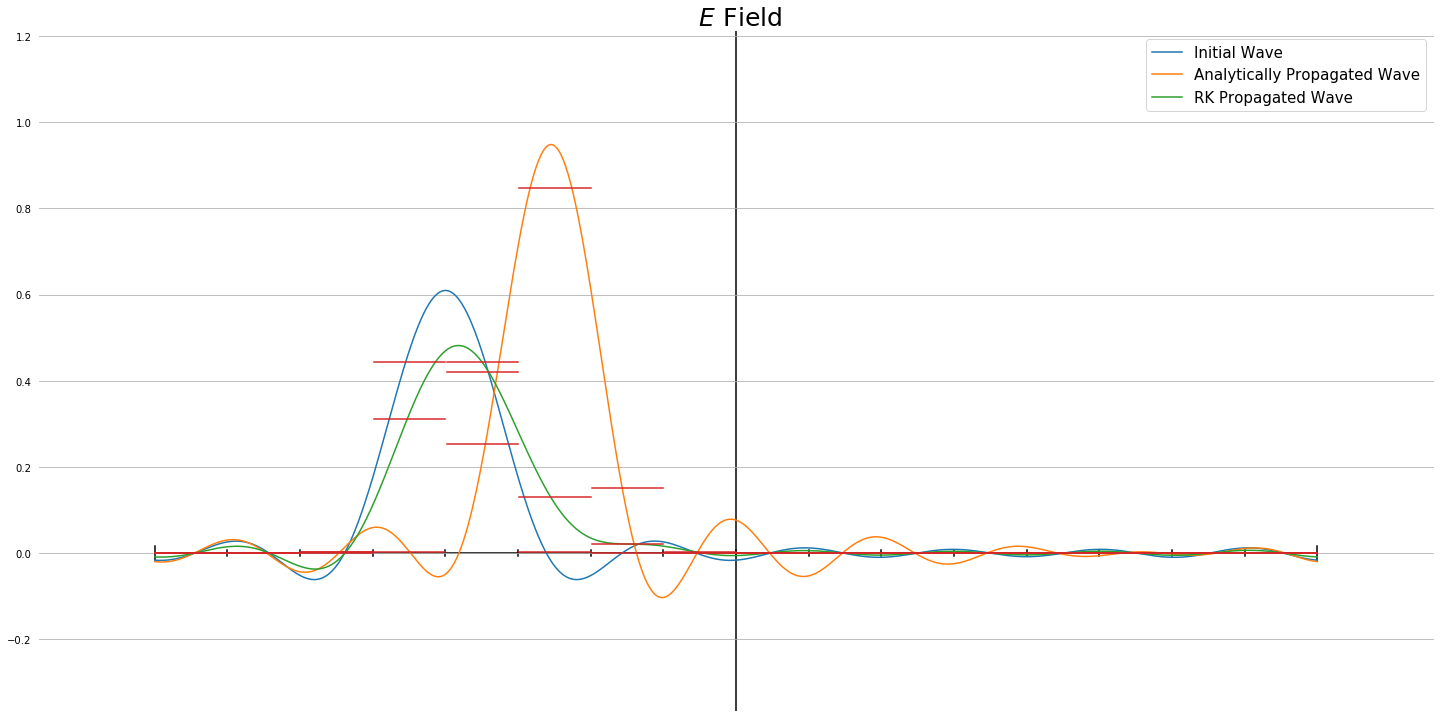

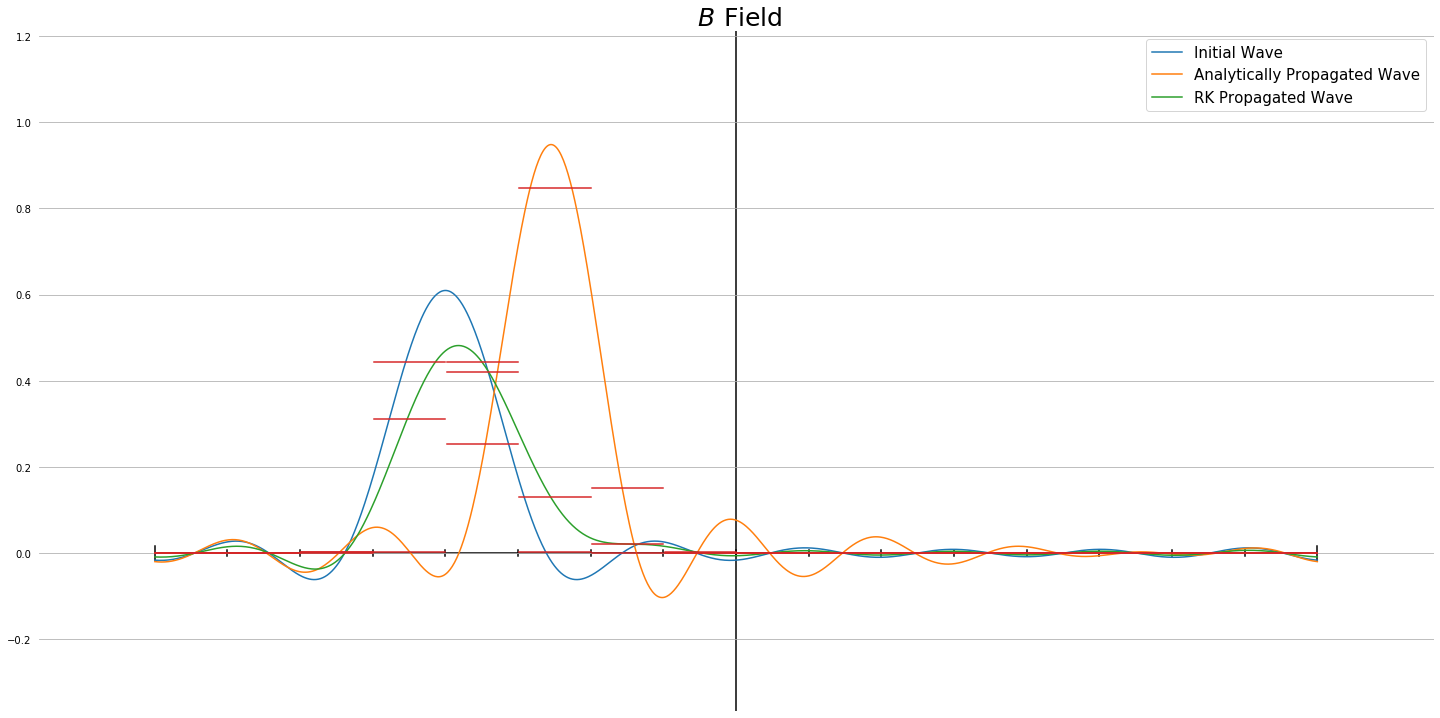

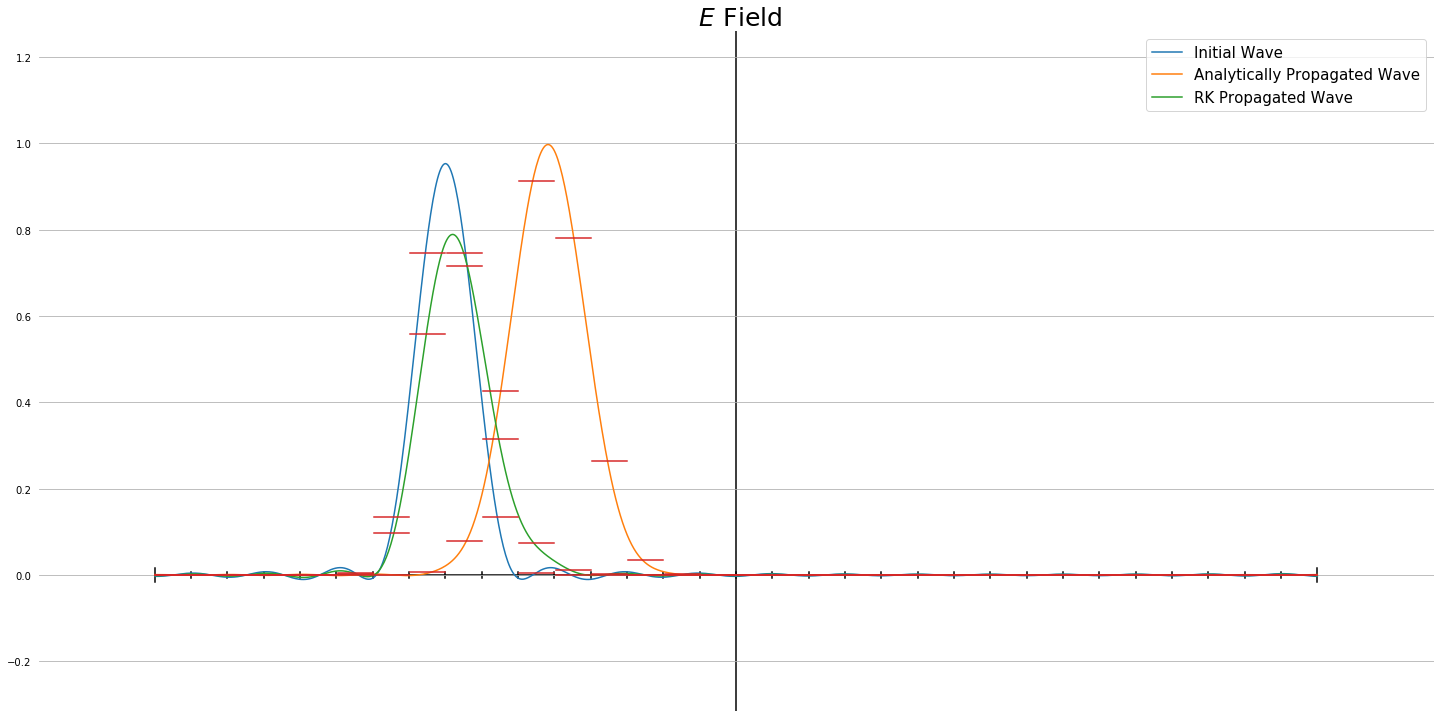

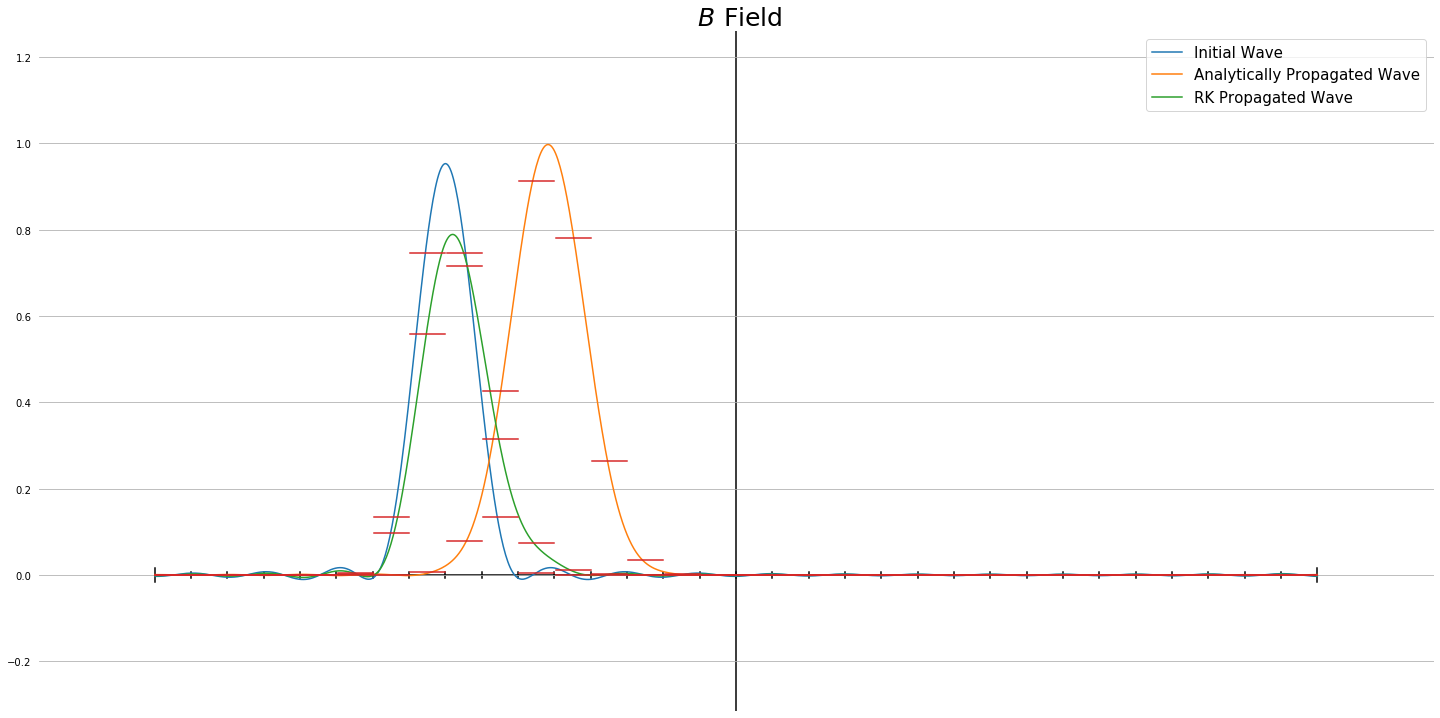

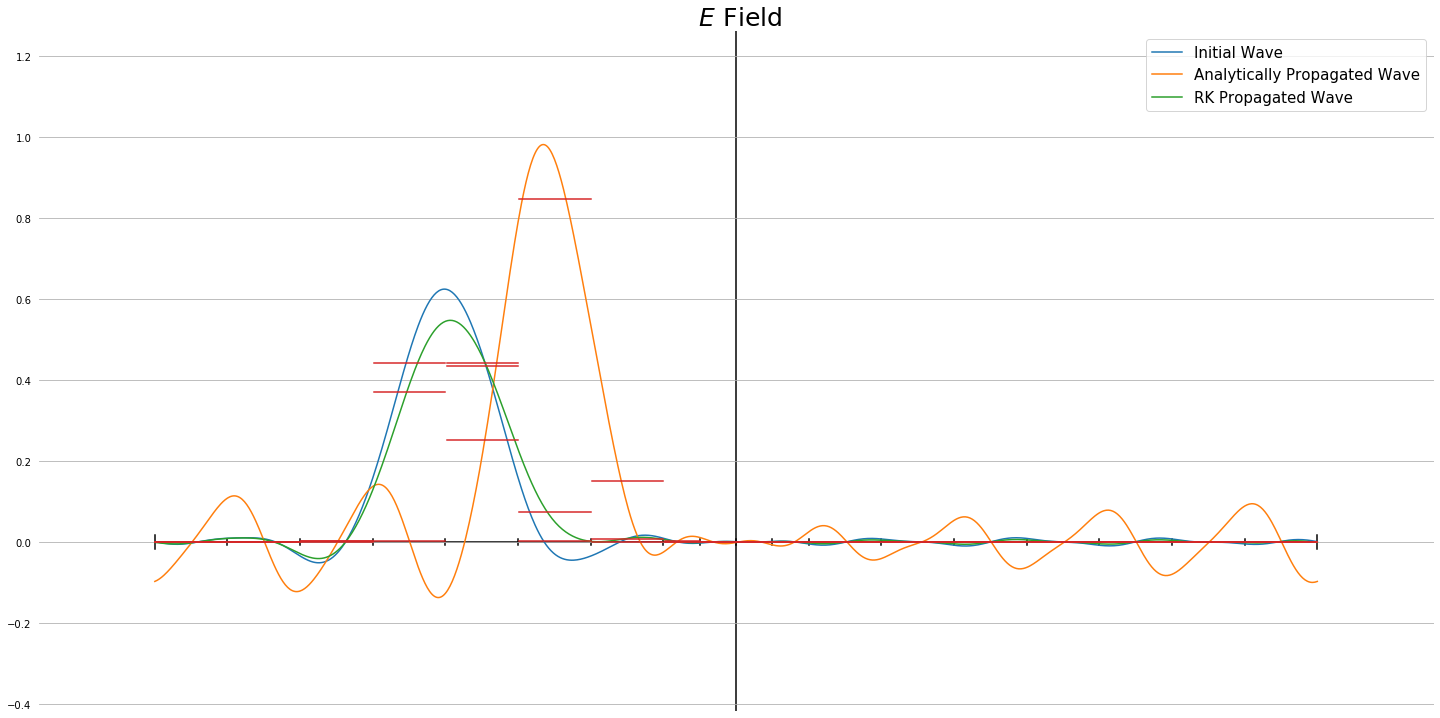

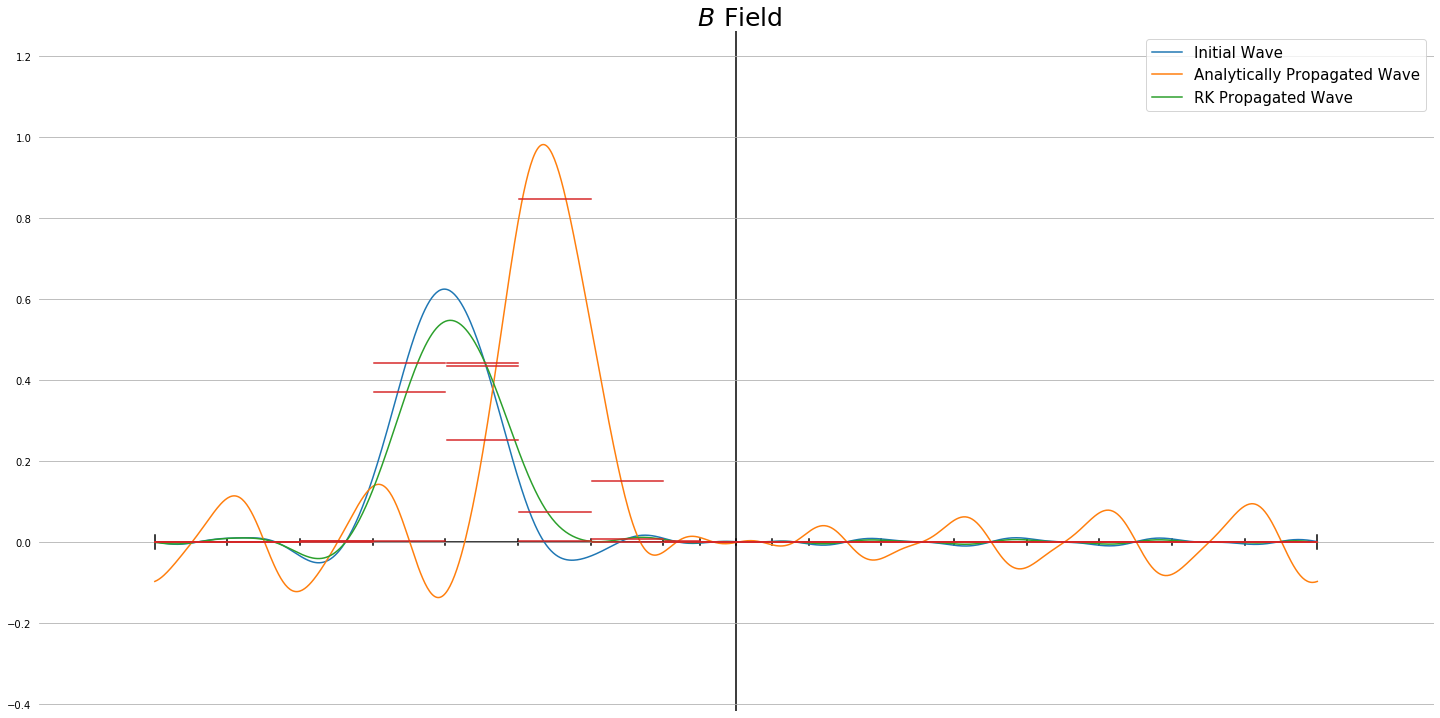

In [13]:
PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, plotCont = plotCont, enlarge = enlarge)#, saveName = 'RKWaveEqAttempt2')#, saveName = 'Coarse', dpi = 300)
PT.PlotMixedWave(omegaF, physicsF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True, labels = labels, enlarge = enlarge, plotCont = plotCont)#, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omegaAMR, physicsAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True, labels = labels, enlarge = enlarge, plotCont = plotCont)#, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


In [33]:
nh_min = 16
refRatio = 2
CFL = np.sqrt(0.5)
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'U'
RK = 4
order = 1

L = 1
locs = [x_1]
epsilons = [1, 0.5] # [1, 1]
mus = [1, 0.5] # [1, 1]

func = WFT.Gauss # SquareWave


omega = BT.Grid(nh_min)
physics = BT.PhysProps(omega, epsilons, mus, locs, L)

sigma, mu = WFT.GaussParams(x_0, x_1)
args = [sigma, mu]

dataPts = 8


[   8   16   32   64  128  256  512 1024]

iter 0
8








n: 0
[0.000013050503785035444   0.21928109563653933       0.2972031403261259        0.0963823234234067        0.03689445646007026       0.006846998435141029      0.0021683342002222867     0.0000002580358217175143  0.000013042440165606192   0.21914555055816715       0.2960761995558472        0.08616730555286321       0.01844722823003513       0.0034234992175705145     0.0010841671001111434     0.00000012901791085875714]

Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?

iter 1
16








n: 0
[0.000000000754850642287652 0.000026092455732577944    0.019586177389050403       0.425757198907331          0.5680210851124332         0.1940827515726056         0.03623324525906377        0.004646992601830265       0.0013450540442028207      0.0000974850500868887      0.0000002580605578757326   0.000000000014929592162934 0.                         0.                         0.           









n: 0
[0.000000000000009345985797 0.000000000000017320220231 0.000000000000030464200529 0.000000000000050250517757 0.000000000000081403560338 0.000000000000133324921491 0.000000000000213733030411 0.000000000000345049809701 0.000000000000555029581528 0.000000000000886410260356 0.000000000001410349317642 0.000000000002236751955683 0.000000000003534276567461 0.000000000005560221485007 0.000000000008713524729656 0.000000000013603168958082 0.000000000021153378453196 0.000000000032766177230048 0.000000000050550326301511 0.000000000077685663798279 0.000000000118917215389552 0.000000000181317742780305 0.000000000275379392813307 0.000000000416593720986678 0.000000000627754140704007 0.000000000942236315999874 0.000000001408711788346621 0.000000002097866640432946 0.000000003111909736630443 0.00000000459799999164556  0.000000006767126000465124 0.000000009920481896271771 0.000000014486198254562767 0.00000002107023114605714  0.000000030526525411862396 0.000000044053320031736915 0.000000063324


iter 7
1024








n: 0
[0.000000000000006230657198 0.000000000000014662142086 0.000000000000017256109399 0.000000000000020806824992 0.000000000000028185919871 0.000000000000036819751034 0.00000000000004878082783  0.00000000000005875100179  0.000000000000077166205745 0.00000000000009559187651  0.000000000000122834593208 0.000000000000159473121653 0.000000000000198889728232 0.000000000000254336600255 0.000000000000324682439368 0.000000000000408664131333 0.000000000000518449692891 0.000000000000658412973208 0.000000000000829334475066 0.000000000001049990664804 0.00000000000132388024982  0.000000000001666658878131 0.000000000002099335434264 0.000000000002640852356601 0.000000000003318504179969 0.000000000004168938097511 0.000000000005225340058606 0.000000000006550302093386 0.00000000000819838617128  0.000000000010250634291846 0.000000000012807464620415 0.000000000015983810387966 0.000000000019929842969908 0.000000000024826111814503 0.000000000030896075201541 0.00000000003840784856952  0


done


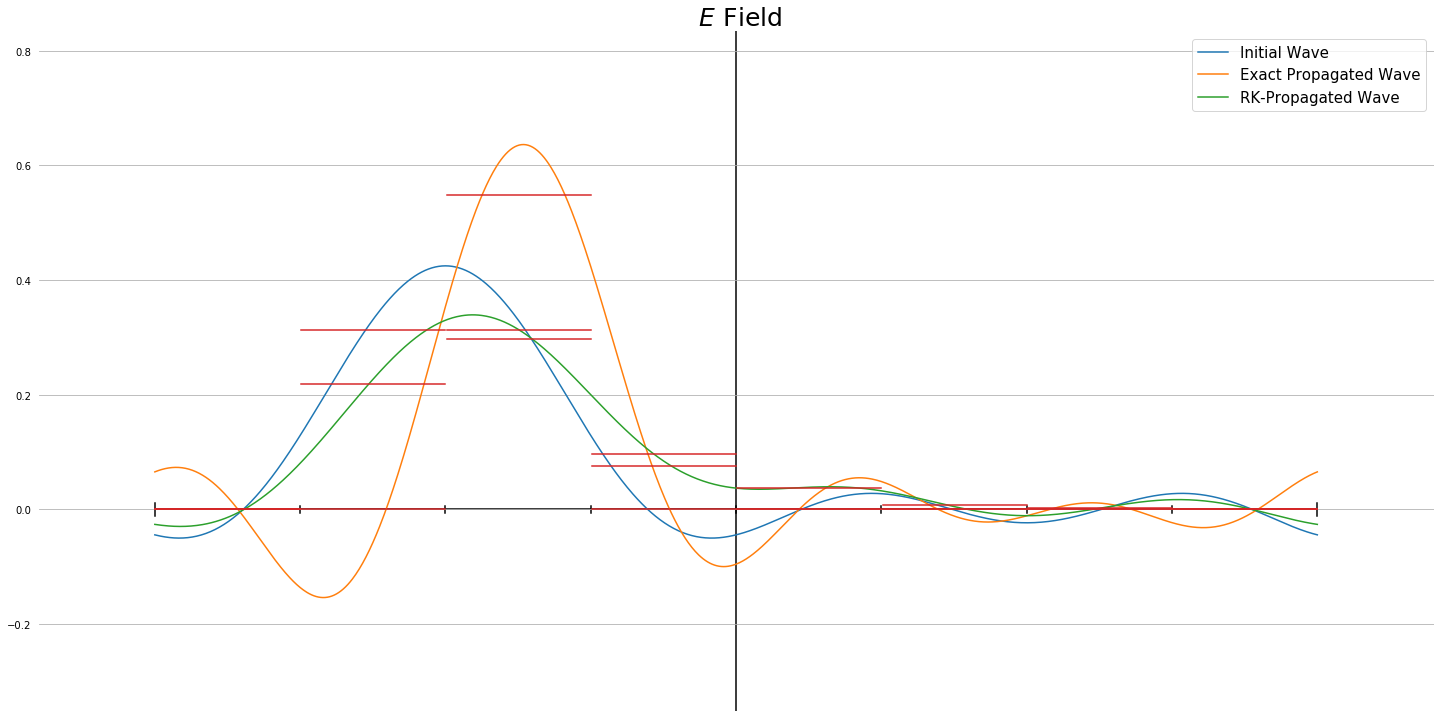

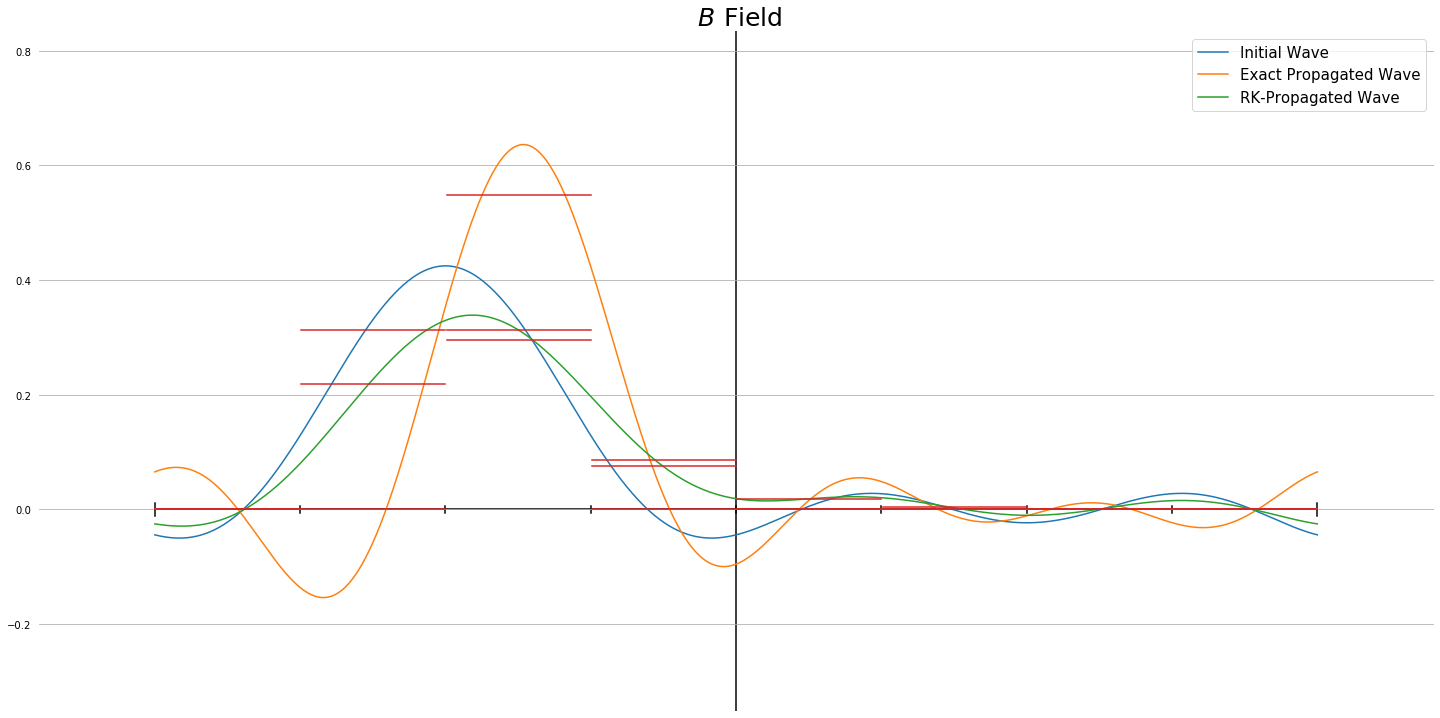

In [34]:
func = WFT.Gauss
args = [sigma, mu]
nt = 1
dataPts = 8
errorE = np.zeros(dataPts, float)
errorB = np.zeros(dataPts, float)
nhPower = np.arange(dataPts) + 1
nhVec = 4 * (2 ** nhPower)
print(nhVec)
print('')

labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']
for i in range(dataPts):
    
    print('iter', i)
    nh_min = 2 ** (i + 3)
    print(nh_min)
    omega = BT.Grid(nh_min)
    physics = BT.PhysProps(omega, epsilons, mus, locs, L)

    c = physics.cVec
    cMat = physics.cMat
    c = c[0]

    t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt)
    waves = WT.MakeWaves(omega)
    wavesMat = OT.Block(waves, var = 2)

    waveInit = WFT.InitCond(omega, physics, func, args)
    FCoefs = FFTT.FourierCoefs(waves, waveInit)

    wavePropEx = WFT.WaveEq(omega, physics, func, args, t)

    # Find propagated coeficients on coarse and fine grid.
    FCoefsProp = FFTT.FourierCoefs(waves, wavePropEx)

    solverCoefs = RungeKutta(omega, physics, waveInit, CFL, nt, RK, order, deriv, WaveEqRHS)
    wavePropSolv = wavesMat @ solverCoefs

    errorVec = abs(wavePropEx - wavePropSolv)
    errorE[i] = TT.VectorNorm(errorVec[:nh_min], 'max')
    errorB[i] = TT.VectorNorm(errorVec[nh_min:], 'max')
    
    allCoefs = PT.Load(FCoefs, FCoefsProp, solverCoefs)
    if (i == 0):
        PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels)
    
    print('')

print('done')

In [35]:
# nhVec, errorTot = WaveEqConvergenceTest(omega, physics, CFL, RK, order, diff, func, args, dataPts)


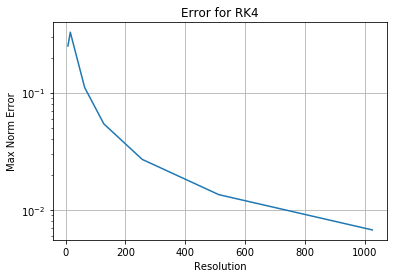

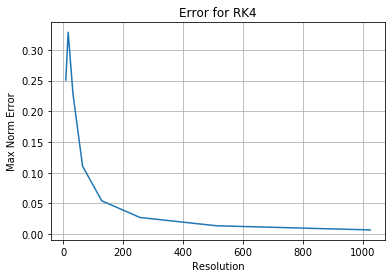

In [36]:
plt.figure()
plt.plot(nhVec, errorE)
plt.title(r'Error for RK' + str(RK))
plt.ylabel('Max Norm Error')
plt.xlabel('Resolution')
# plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(nhVec, errorE)
plt.title(r'Error for RK' + str(RK))
plt.ylabel('Max Norm Error')
plt.xlabel('Resolution')
plt.grid(True)
plt.show()

In [18]:
# First Order RK1
[0.                         0.000000006028348142323653 0.0013763515788428114      0.2868927382768464         0.44263514456158964        0.15787150443732365        0.000752755899098823       0.000000003297013077926455 0.                         0.                         0.                         0.                         0.                         0.                         0.                         0.                         0.                         0.000000006028348142323653 0.0013763515788428114      0.2868927382768464         0.44263514456158964        0.15787150443732365        0.000752755899098823       0.000000003297013077926455 0.                         0.                         0.                         0.                         0.                         0.                         0.                         0.                        ]
[0.00000000e+00             6.02834814e-09             1.37635158e-03             2.86892738e-01             4.42635145e-01             1.57871504e-01             7.52755899e-04             3.29701308e-09             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             6.02834814e-09             1.37635158e-03             2.86892738e-01             4.42635145e-01             1.57871504e-01             7.52755899e-04             3.29701308e-09             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00             0.00000000e+00            ]


SyntaxError: invalid syntax (<ipython-input-18-765ea7371e02>, line 2)

In [ ]:
# Fifth Order RK1
[ 0.00003763584503099508  0.007448391098756216   -0.06854463544396233     0.31301290097204637     0.5464006865369404      0.11927463865946909    -0.05279217775485224     0.0936649902169121     -0.34212057513390354     0.08879488212130698    -0.02257001185191789     0.                      0.                      0.                      0.                      0.                      0.00003763584503099508  0.007448391098756216   -0.06854463544396233     0.31301290097204637     0.5464006865369404      0.11927463865946909    -0.05279217775485224     0.10695646944642827    -0.10409283465438038     0.03311243513469454    -0.011285005925958946    0.                      0.                      0.                      0.                      0.                    ]
[ 3.76358450e-05          7.44839110e-03         -6.85446354e-02          3.13012901e-01          5.46400687e-01          1.19274639e-01         -5.27921778e-02          9.36649902e-02         -3.42120575e-01          8.87948821e-02         -2.25700119e-02          0.00000000e+00          0.00000000e+00          0.00000000e+00          0.00000000e+00          0.00000000e+00          3.76358450e-05          7.44839110e-03         -6.85446354e-02          3.13012901e-01          5.46400687e-01          1.19274639e-01         -5.27921778e-02          1.06956469e-01         -1.04092835e-01          3.31124351e-02         -1.12850059e-02          0.00000000e+00          0.00000000e+00          0.00000000e+00          0.00000000e+00          0.00000000e+00        ]


In [39]:
def WaveEqConvergenceTest(omega0, physics0, CFL, RK, order, diff, func, args, dataPts):
    nh_min = omega0.nh_min
    epsilons = physics0.epsilons
    mus = physics0.mus
    locs = physics0.locs
    L = physics0.L
    
    nt = 1
    errorE = np.zeros(dataPts, float)
    errorB = np.zeros(dataPts, float)
    errorTot = np.zeros(dataPts, float)
    nhPower = np.arange(dataPts)
    nhVec = nh_min * (2 ** nhPower)
    print(nhVec)
    print('')

    labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']
    for i in range(dataPts):

        print('iter', i)
        nh = 2 ** (i + 4)
        print(nh)
        omega = BT.Grid(nh)
        physics = BT.PhysProps(omega, epsilons, mus, locs, L)

        c = physics.cVec
        cMat = physics.cMat
        c1 = c[0]

        t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt)
        waves = WT.MakeWaves(omega)
        wavesMat = OT.Block(waves, var = 2)

        waveInit = WFT.InitCond(omega, physics, func, args)
        FCoefs = FFTT.FourierCoefs(waves, waveInit)

        wavePropEx = WFT.WaveEq(omega, physics, func, args, t)

        # Find propagated coeficients on coarse and fine grid.
        FCoefsProp = FFTT.FourierCoefs(waves, wavePropEx)

        solverCoefs = RungeKutta(omega, physics, waveInit, CFL, nt, RK, order, deriv, WaveEqRHS)
        wavePropSolv = wavesMat @ solverCoefs

        errorVec = abs(wavePropEx - wavePropSolv)
        errorTot[i] = TT.VectorNorm(errorVec, 'max')
        errorE[i] = TT.VectorNorm(errorVec[:nh], 'max')
        errorB[i] = TT.VectorNorm(errorVec[nh:], 'max')

        allCoefs = PT.Load(FCoefs, FCoefsProp, solverCoefs)
        if (i == 3):
            PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels)

        print('')

    print('done')
    return nhVec, errorE
    

In [ ]:
nhVec, errorTot = WaveEqConvergenceTest(omega, physics, CFL, RK, order, diff, func, args, dataPts)


[  1024   2048   4096   8192  16384  32768  65536 131072]

iter 0
16








n: 0
[0.000000000754850642287852 0.000026092455732576717    0.0195861773890504         0.425757198907331          0.5680210851124332         0.1940827515726056         0.036233245259063775       0.004646992601830265       0.0013450540442028205      0.00009748505008688869     0.00000025806055787573257  0.000000000014929592162934 0.                         0.                         0.                         0.                         0.000000000000000002517911 0.000000000000087035063841 0.000000000065332455363144 0.000000001420173147655682 0.00000000189471439226055  0.000000000647390320131454 0.000000000120820342161531 0.000000000014338343789786 0.000000000002243308675255 0.000000000000162587562567 0.000000000000000430398682 0.0000000000000000000249   0.                         0.                         0.                         0.                        ]


iter 1
32








n: 0
[0.00000000000186569241479 

Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?

iter 4
256








n: 0
[0.000000000000011682482247 0.000000000000036837502209 0.000000000000098741850789 0.000000000000256983340173 0.000000000000662810693805 0.000000000001678427752049 0.000000000004186860618876 0.000000000010279291975179 0.000000000024847903055654 0.0000000000591260418988   0.000000000138504603509757 0.000000000319401958815929 0.000000000725104873826542 0.000000001620514168098147 0.000000003565288910829226 0.000000007721941742989752 0.000000016464500562804558 0.00000003455899758394263  0.00000007141090383138348  0.00000014526434912434504  0.0000002909008344678481   0.0000005734857220126315   0.000001112992594757115    0.0000021264455884051006   0.000003999529686566968    0.000007405536823117845    0.000013498871488324578    0.000024223227374419746    0.00004279179548859134     0.00007441891143016012     0.00012740919202682542     0.00021474012652297124     0.00035630









n: 0
[0.000000000000009345985797 0.000000000000017320220231 0.000000000000030464200529 0.000000000000050250517757 0.000000000000081403560338 0.000000000000133324921491 0.000000000000213733030411 0.000000000000345049809701 0.000000000000555029581528 0.000000000000886410260356 0.000000000001410349317642 0.000000000002236751955683 0.000000000003534276567461 0.000000000005560221485007 0.000000000008713524729656 0.000000000013603168958082 0.000000000021153378453196 0.000000000032766177230048 0.000000000050550326301511 0.000000000077685663798279 0.000000000118917215389552 0.000000000181317742780305 0.000000000275379392813307 0.000000000416593720986678 0.000000000627754140704007 0.000000000942236315999874 0.000000001408711788346621 0.000000002097866640432946 0.000000003111909736630443 0.00000000459799999164556  0.000000006767126000465124 0.000000009920481896271771 0.000000014486198254562767 0.00000002107023114605714  0.000000030526525411862396 0.000000044053320031736915 0.000000063324









n: 0
[0.000000000000006230657198 0.000000000000014662142086 0.000000000000017256109399 0.000000000000020806824992 0.000000000000028185919871 0.000000000000036819751034 0.00000000000004878082783  0.00000000000005875100179  0.000000000000077166205745 0.00000000000009559187651  0.000000000000122834593208 0.000000000000159473121653 0.000000000000198889728232 0.000000000000254336600255 0.000000000000324682439368 0.000000000000408664131333 0.000000000000518449692891 0.000000000000658412973208 0.000000000000829334475066 0.000000000001049990664804 0.00000000000132388024982  0.000000000001666658878131 0.000000000002099335434264 0.000000000002640852356601 0.000000000003318504179969 0.000000000004168938097511 0.000000000005225340058606 0.000000000006550302093386 0.00000000000819838617128  0.000000000010250634291846 0.000000000012807464620415 0.000000000015983810387966 0.000000000019929842969908 0.000000000024826111814503 0.000000000030896075201541 0.00000000003840784856952  0.000000000047


iter 7
2048








n: 0
[ 0.000000000000006230657198  0.000000000000008431484888  0.000000000000015055281709  0.000000000000017298356771  0.000000000000017697272857  0.000000000000017739520229  0.000000000000017745296693  0.000000000000023975953891  0.000000000000032407438779  0.000000000000028770748893  0.000000000000033235965397  0.000000000000041322334498  0.0000000000000501104881    0.000000000000052740926321  0.000000000000053182089779  0.000000000000065691428012  0.000000000000076329517053  0.000000000000085547281186  0.000000000000094456400441  0.000000000000103334825251  0.000000000000118438130796  0.000000000000135742264031  0.000000000000153439536888  0.000000000000177409714315  0.000000000000197355838698  0.000000000000215494275013  0.000000000000251973790673  0.000000000000276327346899  0.000000000000313944034055  0.000000000000357110527528  0.000000000000401347027144  0.000000000000445692939485  0.000000000000508748152813  0.000000000000565944534812  0.000000000000638610

In [ ]:
plt.figure()
plt.plot(nhVec, errorTot)
plt.title(r'Error for RK' + str(RK))
plt.ylabel('Max Norm Error')
plt.xlabel('Resolution')
# plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(nhVec, errorTot)
plt.title(r'Error for RK' + str(RK))
plt.ylabel('Max Norm Error')
plt.xlabel('Resolution')
plt.grid(True)
plt.show()